In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import requests
import gzip
import io
import os
from scipy.stats import pearsonr, spearmanr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette(['#EC4899', '#A855F7', '#6366F1', '#3B82F6', '#06B6D4', '#14B8A6', '#22C55E', '#FACC15', '#F97316', '#EF4444'])

print("FACEBOOK EGO-NETWORKS ANALYSIS")
print("Dataset: Social circles from Facebook (SNAP)")
print("\n")

FACEBOOK EGO-NETWORKS ANALYSIS
Dataset: Social circles from Facebook (SNAP)




In [3]:
# Download and load the Facebook combined network
print("Loading Facebook combined network...")
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
response = requests.get(url)
content = gzip.decompress(response.content).decode('utf-8')

Loading Facebook combined network...


In [4]:
# Create graph from edge list
G = nx.parse_edgelist(io.StringIO(content), nodetype=int)

print(f" Network loaded successfully!")
print(f"  - Number of nodes (users): {G.number_of_nodes()}")
print(f"  - Number of edges (friendships): {G.number_of_edges()}")
print(f"  - Network type: {'Connected' if nx.is_connected(G) else 'Disconnected'}")
print("\n")

 Network loaded successfully!
  - Number of nodes (users): 4039
  - Number of edges (friendships): 88234
  - Network type: Connected




In [5]:
# Calculate basic statistics
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

basic_stats = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Average Degree'],
    'Value': [G.number_of_nodes(), G.number_of_edges(), f'{density:.6f}', f'{avg_degree:.2f}'],
    'Description': [
        'Total number of users',
        'Total number of friendships',
        'Ratio of actual to possible connections',
        'Average friends per user'
    ]
})
print("BASIC NETWORK STATISTICS:")
display(basic_stats)
print("\n")

# Calculate degrees for all nodes (used across multiple questions)
degrees = dict(G.degree())

BASIC NETWORK STATISTICS:


,Metric,Value,Description
0,Nodes,4039,Total number of users
1,Edges,88234,Total number of friendships
2,Density,0.010820,Ratio of actual to possible connections
3,Average Degree,43.69,Average friends per user


In [6]:
# RESEARCH QUESTION 1: COMMUNITY STRUCTURE & SOCIAL CLUSTERING

print("RESEARCH QUESTION 1: COMMUNITY STRUCTURE & SOCIAL CLUSTERING")
print("How do friend groups naturally form in the network?")
print("\n")



RESEARCH QUESTION 1: COMMUNITY STRUCTURE & SOCIAL CLUSTERING
How do friend groups naturally form in the network?




In [7]:
# Apply Louvain community detection
communities = nx.community.louvain_communities(G, seed=42)

# Create community membership dictionary
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Calculate modularity
modularity = nx.community.modularity(G, communities)
# Analyze community sizes
community_sizes = [len(c) for c in communities]
community_df = pd.DataFrame({
    'community_id': range(len(communities)),
    'size': community_sizes
}).sort_values('size', ascending=False)
# Calculate internal vs external edges for each community
internal_edges = []
external_edges = []

for community in communities:
    internal = 0
    external = 0
    for node in community:
        for neighbor in G.neighbors(node):
            if neighbor in community:
                internal += 1
            else:
                external += 1
    internal_edges.append(internal // 2)
    external_edges.append(external)
community_df['internal_edges'] = internal_edges
community_df['external_edges'] = external_edges
community_df['cohesion'] = community_df['internal_edges'] / (community_df['internal_edges'] + community_df['external_edges'])



In [8]:
# Summary statistics
community_stats = pd.DataFrame({
    'Metric': [
        'Number of Communities',
        'Modularity Score',
        'Largest Community Size',
        'Smallest Community Size',
        'Average Community Size',
        'Median Community Size',
        'Average Community Cohesion'
    ],
    'Value': [
        f'{len(communities)}',
        f'{modularity:.4f}',
        f'{max(community_sizes)}',
        f'{min(community_sizes)}',
        f'{np.mean(community_sizes):.2f}',
        f'{np.median(community_sizes):.2f}',
        f'{community_df["cohesion"].mean():.4f}']
})

print("COMMUNITY STRUCTURE ANALYSIS:")
display(community_stats)

print("\n")
print("TOP 10 LARGEST COMMUNITIES:")
display(community_df.head(10))
print("\n")
print("KEY FINDINGS:")
print(f"• Network divides into {len(communities)} distinct communities with modularity score of {modularity:.4f}")
print(f"• Largest community: {max(community_sizes)} members ({max(community_sizes)/G.number_of_nodes()*100:.1f}% of network)")
print(f"• Communities are {community_df['cohesion'].mean()*100:.1f}% internally cohesive on average")
print("\n")


COMMUNITY STRUCTURE ANALYSIS:


,Metric,Value
0,Number of Communities,16
1,Modularity Score,0.8349
2,Largest Community Size,548
3,Smallest Community Size,19
4,Average Community Size,252.44
5,Median Community Size,231.50
6,Average Community Cohesion,0.9008




TOP 10 LARGEST COMMUNITIES:


,community_id,size,internal_edges,external_edges,cohesion
14,14,548,2845,52,0.982050
9,9,535,16687,1258,0.929897
1,1,435,1074,378,0.739669
3,3,431,6060,847,0.877371
10,10,423,6303,1012,0.861654
0,0,350,260,27,0.905923
4,4,324,1983,7,0.996482
11,11,237,136,26,0.839506
8,8,226,5600,294,0.950119
6,6,206,8691,479,0.947764




KEY FINDINGS:
• Network divides into 16 distinct communities with modularity score of 0.8349
• Largest community: 548 members (13.6% of network)
• Communities are 90.1% internally cohesive on average




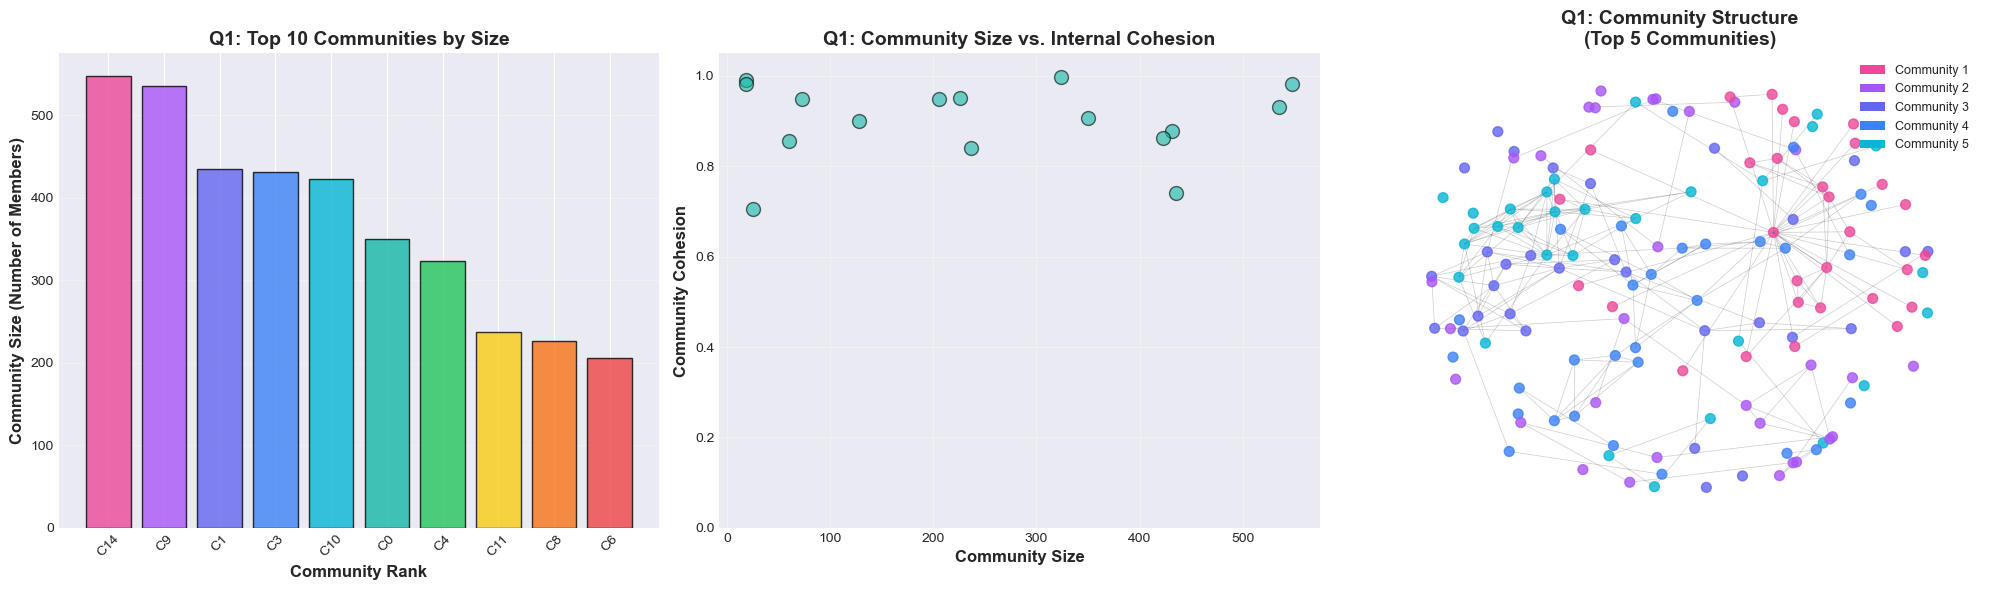

In [9]:
# Visualization for research question 1 - COMMUNITY STRUCTURE & SOCIAL CLUSTERING
fig1, axes1 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Bar Chart - Top 10 Communities by Size
top_10_communities = community_df.head(10)
axes1[0].bar(range(len(top_10_communities)), top_10_communities['size'], 
             color=['#EC4899', '#A855F7', '#6366F1', '#3B82F6', '#06B6D4', '#14B8A6', 
                    '#22C55E', '#FACC15', '#F97316', '#EF4444'], alpha=0.8, edgecolor='black')
axes1[0].set_xlabel('Community Rank', fontsize=12, fontweight='bold')
axes1[0].set_ylabel('Community Size (Number of Members)', fontsize=12, fontweight='bold')
axes1[0].set_title('Q1: Top 10 Communities by Size', fontsize=14, fontweight='bold')
axes1[0].set_xticks(range(len(top_10_communities)))
axes1[0].set_xticklabels([f'C{int(row["community_id"])}' for _, row in top_10_communities.iterrows()], rotation=45)
axes1[0].grid(True, alpha=0.3, axis='y')



# Plot 2: Scatter Plot - Community Size vs Cohesion
axes1[1].scatter(community_df['size'], community_df['cohesion'], 
                 alpha=0.6, s=100, color='#14B8A6', edgecolors='black', linewidth=1)
axes1[1].set_xlabel('Community Size', fontsize=12, fontweight='bold')
axes1[1].set_ylabel('Community Cohesion', fontsize=12, fontweight='bold')
axes1[1].set_title('Q1: Community Size vs. Internal Cohesion', fontsize=14, fontweight='bold')
axes1[1].grid(True, alpha=0.3)
axes1[1].set_ylim([0, 1.05])


# Plot 3: NETWORK GRAPH - Community Structure Visualization

# Sample nodes from top 5 communities for visualization
sampled_nodes = []
top_5_communities = sorted(communities, key=len, reverse=True)[:5]
for i, community in enumerate(top_5_communities):

# Sample up to 30 nodes per community
    sample_size = min(30, len(community))
    sampled_nodes.extend(list(community)[:sample_size])
    
# Create subgraph
G_sample = G.subgraph(sampled_nodes)

# Create layout
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)

# Assign colors based on community
node_colors = []
color_map = ['#EC4899', '#A855F7', '#6366F1', '#3B82F6', '#06B6D4']
for node in G_sample.nodes():
    comm_id = community_map[node]
    
# Find which of top 5 communities this node belongs to
    for i, community in enumerate(top_5_communities):
        if node in community:
            node_colors.append(color_map[i])
            break

# Draw network
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=50, 
                       alpha=0.8, ax=axes1[2])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes1[2])

axes1[2].set_title('Q1: Community Structure\n(Top 5 Communities)', 
                   fontsize=14, fontweight='bold')
axes1[2].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[i], label=f'Community {i+1}') 
                   for i in range(5)]
axes1[2].legend(handles=legend_elements, loc='upper right', fontsize=9)



plt.tight_layout()
plt.show()

In [10]:
# RESEARCH QUESTION 2: THE FRIENDSHIP PARADOX
print("\n")
print("RESEARCH QUESTION 2: THE FRIENDSHIP PARADOX")
print("Do your friends have more friends than you do?")





RESEARCH QUESTION 2: THE FRIENDSHIP PARADOX
Do your friends have more friends than you do?


In [11]:
# For each node, calculate average degree of neighbors
user_degree = []
friend_avg_degree = []

for node in G.nodes():
    my_degree = degrees[node]
    neighbors = list(G.neighbors(node))
    
    if len(neighbors) > 0:
        avg_friend_degree = sum(degrees[neighbor] for neighbor in neighbors) / len(neighbors)
        user_degree.append(my_degree)
        friend_avg_degree.append(avg_friend_degree)
        
# Create dataframe
paradox_df = pd.DataFrame({
    'user_degree': user_degree,
    'friend_avg_degree': friend_avg_degree,
    'difference': [f - u for u, f in zip(user_degree, friend_avg_degree)]
})

# Calculate statistics
avg_user_degree = np.mean(user_degree)
avg_friend_degree = np.mean(friend_avg_degree)
paradox_magnitude = avg_friend_degree - avg_user_degree
pct_experiencing_paradox = (paradox_df['difference'] > 0).sum() / len(paradox_df) * 100





In [12]:
# Summary statistics
paradox_stats = pd.DataFrame({
    'Metric': [
        'Average User Degree',
        'Average Friend Degree',
        'Paradox Magnitude',
        '% Users Experiencing Paradox',
        'Maximum User Degree',
        'Maximum Friend Avg Degree'
    ],
    'Value': [
        f'{avg_user_degree:.2f}',
        f'{avg_friend_degree:.2f}',
        f'{paradox_magnitude:.2f}',
        f'{pct_experiencing_paradox:.1f}%',
        f'{max(user_degree)}',
        f'{max(friend_avg_degree):.2f}'
    ]
})

print("FRIENDSHIP PARADOX ANALYSIS:")
display(paradox_stats)

print("\n")
print("KEY FINDINGS:")
print(f"• Average user has {avg_user_degree:.1f} friends, but their friends average {avg_friend_degree:.1f} friends")
print(f"• {pct_experiencing_paradox:.1f}% of users experience the paradox (friends have more friends)")
print(f"• Paradox magnitude: {paradox_magnitude:.2f} friends difference")
print("\n")

FRIENDSHIP PARADOX ANALYSIS:


,Metric,Value
0,Average User Degree,43.69
1,Average Friend Degree,105.55
2,Paradox Magnitude,61.86
3,% Users Experiencing Paradox,87.5%
4,Maximum User Degree,1045
5,Maximum Friend Avg Degree,1045.00




KEY FINDINGS:
• Average user has 43.7 friends, but their friends average 105.6 friends
• 87.5% of users experience the paradox (friends have more friends)
• Paradox magnitude: 61.86 friends difference




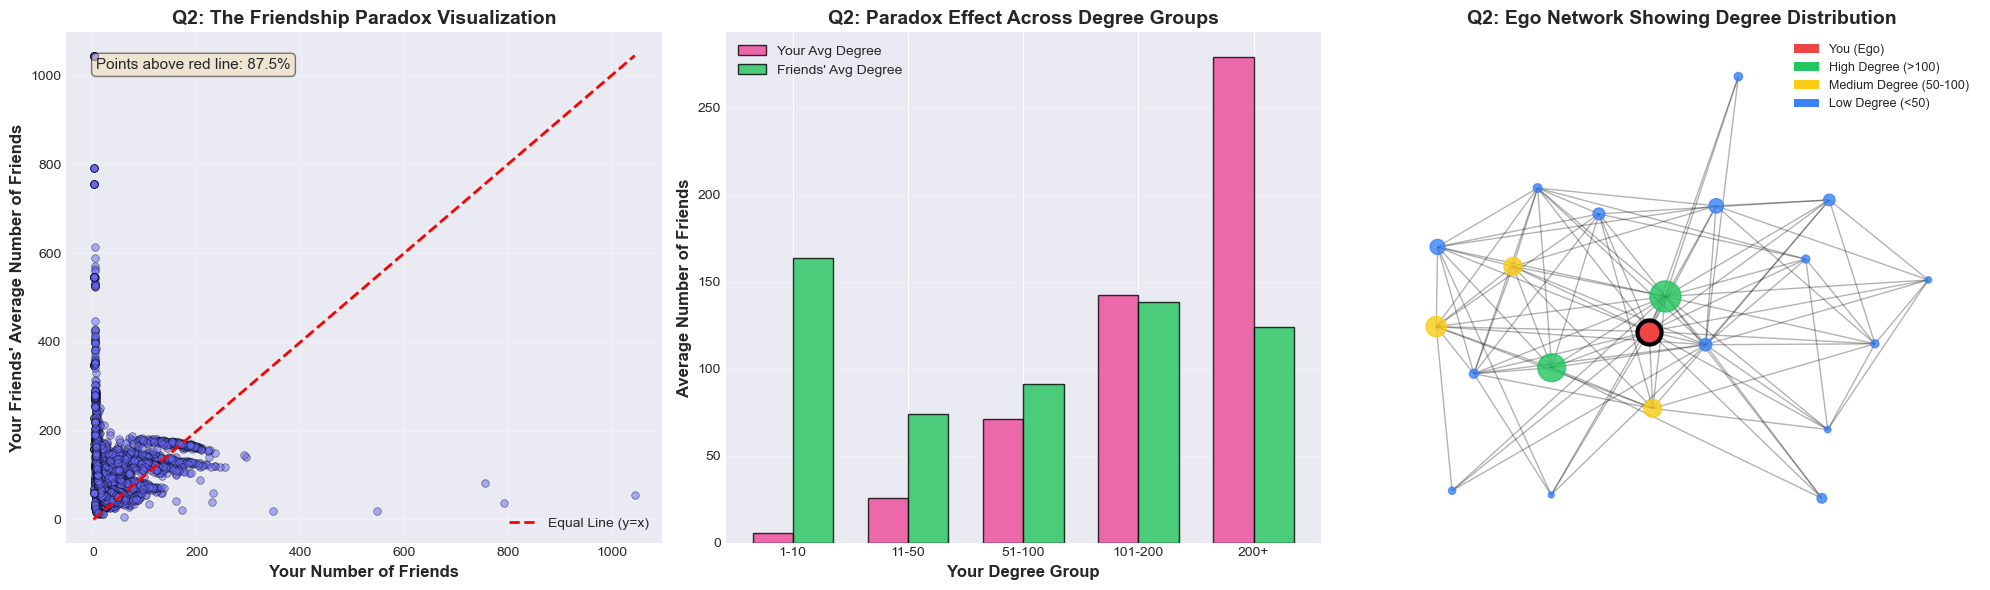

In [13]:
# Visualization: 3 plots for RESEARCH QUESTION 2: THE FRIENDSHIP PARADOX

fig2, axes2 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Scatter plot comparing user degree vs friend average degree
axes2[0].scatter(paradox_df['user_degree'], paradox_df['friend_avg_degree'], 
                alpha=0.5, s=30, color='#6366F1', edgecolors='black', linewidth=0.5)
axes2[0].plot([0, max(user_degree)], [0, max(user_degree)], 'r--', linewidth=2, label='Equal Line (y=x)')
axes2[0].set_xlabel('Your Number of Friends', fontsize=12, fontweight='bold')
axes2[0].set_ylabel("Your Friends' Average Number of Friends", fontsize=12, fontweight='bold')
axes2[0].set_title('Q2: The Friendship Paradox Visualization', fontsize=14, fontweight='bold')
axes2[0].legend()
axes2[0].grid(True, alpha=0.3)
axes2[0].text(0.05, 0.95, f'Points above red line: {pct_experiencing_paradox:.1f}%', 
             transform=axes2[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Bar chart - Paradox effect by degree bins
paradox_df['degree_bin'] = pd.cut(paradox_df['user_degree'], 
                                   bins=[0, 10, 50, 100, 200, 1100], 
                                   labels=['1-10', '11-50', '51-100', '101-200', '200+'])
degree_groups = paradox_df.groupby('degree_bin', observed=True).agg({
    'user_degree': 'mean',
    'friend_avg_degree': 'mean'
}).reset_index()

x_pos = np.arange(len(degree_groups))
width = 0.35
axes2[1].bar(x_pos - width/2, degree_groups['user_degree'], width, 
             label='Your Avg Degree', color='#EC4899', alpha=0.8, edgecolor='black')
axes2[1].bar(x_pos + width/2, degree_groups['friend_avg_degree'], width, 
             label="Friends' Avg Degree", color='#22C55E', alpha=0.8, edgecolor='black')
axes2[1].set_xlabel('Your Degree Group', fontsize=12, fontweight='bold')
axes2[1].set_ylabel('Average Number of Friends', fontsize=12, fontweight='bold')
axes2[1].set_title('Q2: Paradox Effect Across Degree Groups', fontsize=14, fontweight='bold')
axes2[1].set_xticks(x_pos)
axes2[1].set_xticklabels(degree_groups['degree_bin'])
axes2[1].legend()
axes2[1].grid(True, alpha=0.3, axis='y')

# Plot 3: NETWORK GRAPH - Friendship Paradox Illustration

# Select one user with moderate degree and show their friends
sample_user = [node for node in G.nodes() if 20 <= degrees[node] <= 40][0]
ego_network = nx.ego_graph(G, sample_user, radius=1)

# Get degrees for ego network
ego_degrees = {node: degrees[node] for node in ego_network.nodes()}

# Create layout
pos_ego = nx.spring_layout(ego_network, k=1, iterations=50, seed=42)

# Color nodes by degree (darker = more friends)
node_colors_ego = []
for node in ego_network.nodes():
    if node == sample_user:
        node_colors_ego.append('#EF4444')  # Red for ego
    else:
        # Scale color by degree
        degree_val = ego_degrees[node]
        if degree_val > 100:
            node_colors_ego.append('#22C55E')  # Green for high degree
        elif degree_val > 50:
            node_colors_ego.append('#FACC15')  # Yellow for medium
        else:
            node_colors_ego.append('#3B82F6')  # Blue for low

# Node sizes proportional to degree
node_sizes_ego = [min(ego_degrees[node] * 3, 500) for node in ego_network.nodes()]

# Draw network
nx.draw_networkx_nodes(ego_network, pos_ego, node_color=node_colors_ego, 
                       node_size=node_sizes_ego, alpha=0.8, ax=axes2[2])
nx.draw_networkx_edges(ego_network, pos_ego, alpha=0.3, width=1, ax=axes2[2])

# Highlight the ego node
nx.draw_networkx_nodes(ego_network, pos_ego, nodelist=[sample_user], 
                       node_color='#EF4444', node_size=300, 
                       edgecolors='black', linewidths=3, ax=axes2[2])

axes2[2].set_title('Q2: Ego Network Showing Degree Distribution',
                   fontsize=14, fontweight='bold')
axes2[2].axis('off')

# Add legend
legend_elements_ego = [
    Patch(facecolor='#EF4444', label='You (Ego)'),
    Patch(facecolor='#22C55E', label='High Degree (>100)'),
    Patch(facecolor='#FACC15', label='Medium Degree (50-100)'),
    Patch(facecolor='#3B82F6', label='Low Degree (<50)')
]
axes2[2].legend(handles=legend_elements_ego, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


In [14]:
# RESEARCH QUESTION 3: TRIADIC CLOSURE & TRANSITIVITY
print("\n")
print("RESEARCH QUESTION 3: TRIADIC CLOSURE & TRANSITIVITY")
print("If A is friends with B, and B is friends with C, how likely is A to be friends with C?")
print("\n")





RESEARCH QUESTION 3: TRIADIC CLOSURE & TRANSITIVITY
If A is friends with B, and B is friends with C, how likely is A to be friends with C?




In [15]:
# Calculate global clustering coefficient (transitivity)
transitivity = nx.transitivity(G)

# Calculate average clustering coefficient
avg_clustering = nx.average_clustering(G)

# Calculate local clustering for each node
local_clustering = nx.clustering(G)

# Count triangles
triangles = sum(nx.triangles(G).values()) // 3

# Calculate number of possible triads (connected triples)
possible_triads = sum(degrees[node] * (degrees[node] - 1) // 2 for node in G.nodes())

# Create dataframe with clustering by degree
clustering_by_degree = []
for node in G.nodes():
    clustering_by_degree.append({
        'node': node,
        'degree': degrees[node],
        'clustering': local_clustering[node],
        'triangles': nx.triangles(G, node)
    })

clustering_df = pd.DataFrame(clustering_by_degree)

# Group by degree bins
clustering_df['degree_bin'] = pd.cut(clustering_df['degree'], bins=[0, 10, 50, 100, 200, 1100], 
                                       labels=['1-10', '11-50', '51-100', '101-200', '200+'])
degree_clustering = clustering_df.groupby('degree_bin', observed=True).agg({
    'clustering': 'mean',
    'degree': 'mean',
    'triangles': 'mean'
}).reset_index()



In [16]:
# Summary statistics
triadic_stats = pd.DataFrame({
    'Metric': [
        'Global Clustering Coefficient',
        'Average Local Clustering',
        'Number of Triangles',
        'Possible Triads',
        'Transitivity Ratio'
    ],
    'Value': [
        f'{transitivity:.4f}',
        f'{avg_clustering:.4f}',
        f'{triangles:,}',
        f'{possible_triads:,}',
        f'{triangles/possible_triads:.4f}' if possible_triads > 0 else '0'
    ]
})
print("TRIADIC CLOSURE ANALYSIS:")
display(triadic_stats)

print("\n")
print("CLUSTERING BY DEGREE GROUP:")
display(degree_clustering)

print("\n")
print("KEY FINDINGS:")
print(f"• Global clustering coefficient: {transitivity:.4f} ({transitivity*100:.2f}% of connected triples form triangles)")
print(f"• Network has {triangles:,} triangles (closed triads)")
print(f"• Average user has {avg_clustering*100:.2f}% of possible triangles in their neighborhood")
print("\n")

TRIADIC CLOSURE ANALYSIS:


,Metric,Value
0,Global Clustering Coefficient,0.5192
1,Average Local Clustering,0.6055
2,Number of Triangles,"1,612,010"
3,Possible Triads,"9,314,849"
4,Transitivity Ratio,0.1731




CLUSTERING BY DEGREE GROUP:


,degree_bin,clustering,degree,triangles
0,1-10,0.718196,5.648958,12.198958
1,11-50,0.574301,25.694057,206.811370
2,51-100,0.527735,71.283560,1385.414781
3,101-200,0.627336,142.609977,6801.140590
4,200+,0.462997,279.375000,12657.650000




KEY FINDINGS:
• Global clustering coefficient: 0.5192 (51.92% of connected triples form triangles)
• Network has 1,612,010 triangles (closed triads)
• Average user has 60.55% of possible triangles in their neighborhood




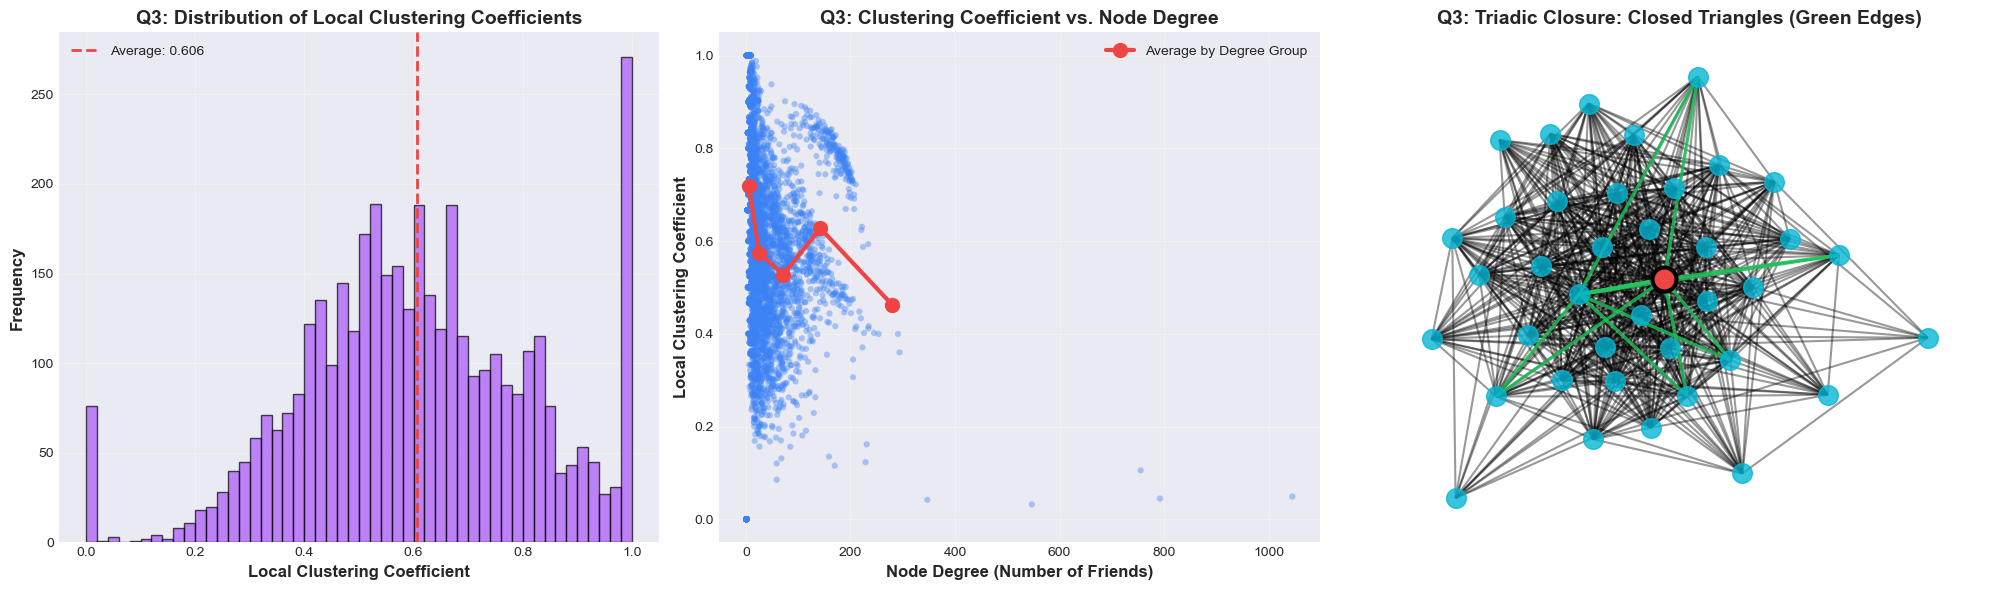

In [17]:
# Visualization: 3 plots for research question 3 - TRIADIC CLOSURE & TRANSITIVITY

fig3, axes3 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Clustering coefficient distribution
axes3[0].hist(list(local_clustering.values()), bins=50, color='#A855F7', alpha=0.7, edgecolor='black')
axes3[0].axvline(avg_clustering, color='#EF4444', linestyle='--', linewidth=2, label=f'Average: {avg_clustering:.3f}')
axes3[0].set_xlabel('Local Clustering Coefficient', fontsize=12, fontweight='bold')
axes3[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes3[0].set_title('Q3: Distribution of Local Clustering Coefficients', fontsize=14, fontweight='bold')
axes3[0].legend()
axes3[0].grid(True, alpha=0.3)

# Plot 2: Clustering vs Degree
axes3[1].scatter(clustering_df['degree'], clustering_df['clustering'], 
                alpha=0.4, s=20, color='#3B82F6', edgecolors='none')
axes3[1].plot(degree_clustering['degree'], degree_clustering['clustering'], 
             color='#EF4444', linewidth=3, marker='o', markersize=10, label='Average by Degree Group')
axes3[1].set_xlabel('Node Degree (Number of Friends)', fontsize=12, fontweight='bold')
axes3[1].set_ylabel('Local Clustering Coefficient', fontsize=12, fontweight='bold')
axes3[1].set_title('Q3: Clustering Coefficient vs. Node Degree', fontsize=14, fontweight='bold')
axes3[1].legend()
axes3[1].grid(True, alpha=0.3)

# Plot 3: NETWORK GRAPH - Triadic Closure Example

# Find a node with high clustering and moderate degree
high_clustering_nodes = [node for node in G.nodes() 
                         if 30 <= degrees[node] <= 60 and local_clustering[node] > 0.7]
if high_clustering_nodes:
    sample_node = high_clustering_nodes[0]
else:
    sample_node = list(G.nodes())[0]

# Get ego network
triad_network = nx.ego_graph(G, sample_node, radius=1)

# Create layout
pos_triad = nx.spring_layout(triad_network, k=1.5, iterations=50, seed=42)

# Find triangles in this ego network
triangles_in_ego = []
for node1 in triad_network.nodes():
    for node2 in triad_network.neighbors(node1):
        for node3 in triad_network.neighbors(node2):
            if triad_network.has_edge(node1, node3) and node1 < node2 < node3:
                triangles_in_ego.append((node1, node2, node3))

# Draw network
nx.draw_networkx_nodes(triad_network, pos_triad, node_color='#06B6D4', 
                       node_size=200, alpha=0.8, ax=axes3[2])
nx.draw_networkx_edges(triad_network, pos_triad, alpha=0.4, width=1.5, ax=axes3[2])

# Highlight the ego node
nx.draw_networkx_nodes(triad_network, pos_triad, nodelist=[sample_node], 
                       node_color='#EF4444', node_size=300, 
                       edgecolors='black', linewidths=3, ax=axes3[2])

# Highlight triangle edges in green
if triangles_in_ego:
    triangle_edges = []
    for t in triangles_in_ego[:5]:  # Show first 5 triangles
        triangle_edges.extend([(t[0], t[1]), (t[1], t[2]), (t[0], t[2])])
    nx.draw_networkx_edges(triad_network, pos_triad, edgelist=triangle_edges,
                          edge_color='#22C55E', width=2.5, alpha=0.8, ax=axes3[2])

axes3[2].set_title('Q3: Triadic Closure: Closed Triangles (Green Edges)', 
                   fontsize=14, fontweight='bold')
axes3[2].axis('off')

plt.tight_layout()
plt.show()


In [18]:
# RESEARCH QUESTION 4: BRIDGE NODES & STRUCTURAL HOLES

print("\n")
print("RESEARCH QUESTION 4: BRIDGE NODES & STRUCTURAL HOLES")
print("Who are the brokers connecting different communities?")
print("\n")
print("Identifying bridge nodes and structural holes...")





RESEARCH QUESTION 4: BRIDGE NODES & STRUCTURAL HOLES
Who are the brokers connecting different communities?


Identifying bridge nodes and structural holes...


In [19]:
# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(G, k=min(1000, G.number_of_nodes()))

# Calculate degree centrality for comparison
degree_centrality = nx.degree_centrality(G)

# Create dataframe
bridge_df = pd.DataFrame({
    'node': list(G.nodes()),
    'betweenness': [betweenness[node] for node in G.nodes()],
    'degree': [degrees[node] for node in G.nodes()],
    'degree_centrality': [degree_centrality[node] for node in G.nodes()]
})
# Calculate brokerage score: high betweenness relative to degree
bridge_df['brokerage_score'] = bridge_df['betweenness'] / (bridge_df['degree_centrality'] + 0.001)

# Sort by betweenness
bridge_df = bridge_df.sort_values('betweenness', ascending=False)

# Identify pure brokers (high betweenness, moderate degree)
median_degree = bridge_df['degree'].median()
pure_brokers = bridge_df[
    (bridge_df['betweenness'] > bridge_df['betweenness'].quantile(0.90)) &
    (bridge_df['degree'] < bridge_df['degree'].quantile(0.75))
]




In [20]:
print("TOP 10 BRIDGE NODES (by Betweenness Centrality):")
top_bridges = bridge_df.head(10)[['node', 'betweenness', 'degree', 'brokerage_score']]
display(top_bridges)

print("\n")
print("TOP 10 PURE BROKERS (High Betweenness, Moderate Degree):")
if len(pure_brokers) >= 10:
    display(pure_brokers.head(10)[['node', 'betweenness', 'degree', 'brokerage_score']])
else:
    display(pure_brokers[['node', 'betweenness', 'degree', 'brokerage_score']])
    

TOP 10 BRIDGE NODES (by Betweenness Centrality):


,node,betweenness,degree,brokerage_score
107,107,0.484538,1045,1.865104
351,1684,0.338768,792,1.718444
1821,3437,0.228560,547,1.674887
352,1912,0.227639,755,1.211017
0,0,0.145500,347,1.673693
571,1085,0.145329,66,8.378879
1843,698,0.118768,68,6.657378
1710,567,0.093309,63,5.620397
58,58,0.083909,12,21.126335
350,428,0.064358,115,2.183139




TOP 10 PURE BROKERS (High Betweenness, Moderate Degree):


,node,betweenness,degree,brokerage_score
58,58,0.083909,12,21.126335
2006,860,0.058703,2,39.258434
1754,594,0.026259,8,8.808361
171,171,0.015780,22,2.447252
2008,862,0.012729,24,1.833208
1020,1534,0.006691,33,0.729519
1152,1666,0.005885,36,0.593501
891,1405,0.004084,50,0.305181
34,34,0.003485,5,1.556943
173,173,0.003454,12,0.869741


In [21]:
# Summary statistics
bridge_stats = pd.DataFrame({
    'Metric': [
        'Avg Betweenness Centrality',
        'Max Betweenness Centrality',
        'Nodes with High Betweenness (>90th percentile)',
        'Pure Brokers Identified',
        'Top Broker Betweenness',
        'Top Broker Degree'
    ],
    'Value': [
        f'{bridge_df["betweenness"].mean():.6f}',
        f'{bridge_df["betweenness"].max():.6f}',
        f'{(bridge_df["betweenness"] > bridge_df["betweenness"].quantile(0.90)).sum()}',
        f'{len(pure_brokers)}',
        f'{bridge_df.iloc[0]["betweenness"]:.6f}',
        f'{int(bridge_df.iloc[0]["degree"])}'
    ]
})

print("\n")
print("BRIDGE NODE STATISTICS:")
display(bridge_stats)
print("\n")
print("KEY FINDINGS:")
print(f"• Top bridge node (Node {int(bridge_df.iloc[0]['node'])}) controls {bridge_df.iloc[0]['betweenness']*100:.3f}% of shortest paths")
print(f"• Identified {len(pure_brokers)} pure brokers (high betweenness, moderate connections)")
print(f"• {(bridge_df['betweenness'] > bridge_df['betweenness'].quantile(0.90)).sum()} nodes (top 10%) control most information flow")
print("\n")



BRIDGE NODE STATISTICS:


,Metric,Value
0,Avg Betweenness Centrality,0.000665
1,Max Betweenness Centrality,0.484538
2,Nodes with High Betweenness (>90th percentile),404
3,Pure Brokers Identified,171
4,Top Broker Betweenness,0.484538
5,Top Broker Degree,1045




KEY FINDINGS:
• Top bridge node (Node 107) controls 48.454% of shortest paths
• Identified 171 pure brokers (high betweenness, moderate connections)
• 404 nodes (top 10%) control most information flow




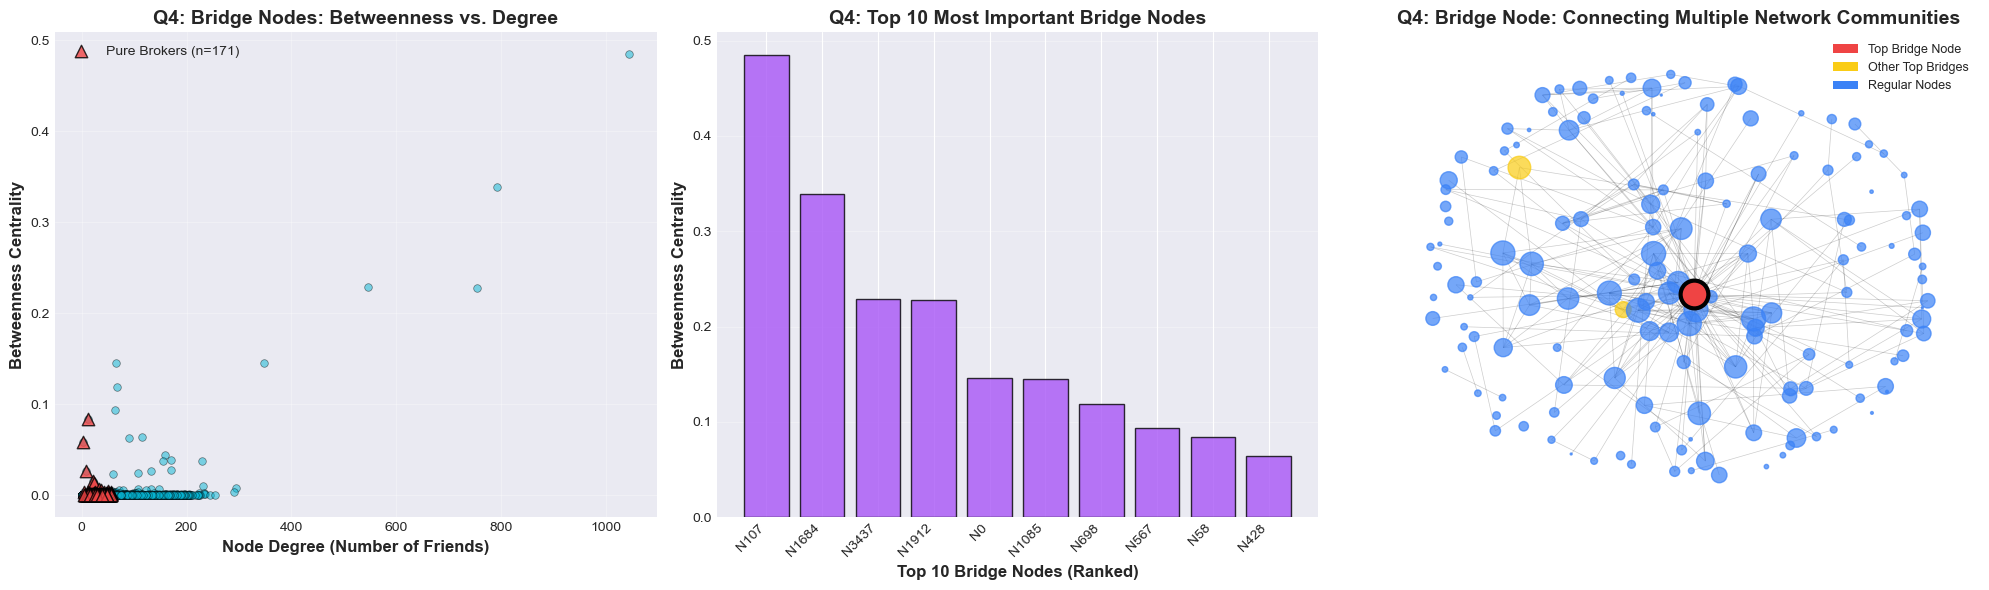

In [22]:
# Visualization: 3 plots for research question 4- BRIDGE NODES & STRUCTURAL HOLES

fig4, axes4 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Betweenness vs Degree (identifying brokers)
axes4[0].scatter(bridge_df['degree'], bridge_df['betweenness'], 
                alpha=0.5, s=30, color='#06B6D4', edgecolors='black', linewidth=0.5)
if len(pure_brokers) > 0:
    axes4[0].scatter(pure_brokers['degree'], pure_brokers['betweenness'], 
                    alpha=0.8, s=80, color='#EF4444', edgecolors='black', linewidth=1, 
                    label=f'Pure Brokers (n={len(pure_brokers)})', marker='^')
axes4[0].set_xlabel('Node Degree (Number of Friends)', fontsize=12, fontweight='bold')
axes4[0].set_ylabel('Betweenness Centrality', fontsize=12, fontweight='bold')
axes4[0].set_title('Q4: Bridge Nodes: Betweenness vs. Degree', fontsize=14, fontweight='bold')
axes4[0].legend()
axes4[0].grid(True, alpha=0.3)

# Plot 2: Top 10 brokers comparison
top_10_brokers = bridge_df.head(10)
x_pos = np.arange(len(top_10_brokers))
axes4[1].bar(x_pos, top_10_brokers['betweenness'], color='#A855F7', alpha=0.8, edgecolor='black')
axes4[1].set_xlabel('Top 10 Bridge Nodes (Ranked)', fontsize=12, fontweight='bold')
axes4[1].set_ylabel('Betweenness Centrality', fontsize=12, fontweight='bold')
axes4[1].set_title('Q4: Top 10 Most Important Bridge Nodes', fontsize=14, fontweight='bold')
axes4[1].set_xticks(x_pos)
axes4[1].set_xticklabels([f'N{int(row["node"])}' for _, row in top_10_brokers.iterrows()], rotation=45, ha='right')
axes4[1].grid(True, alpha=0.3, axis='y')

# Plot 3: NETWORK GRAPH - Bridge Nodes Visualization

# Get top bridge node
top_bridge = int(bridge_df.iloc[0]['node'])

# Get 2-hop neighborhood to show bridging
bridge_network = nx.ego_graph(G, top_bridge, radius=2)

# Sample if too large
if len(bridge_network.nodes()) > 150:
    # Keep top bridge and sample others
    nodes_to_keep = [top_bridge]
    other_nodes = [n for n in bridge_network.nodes() if n != top_bridge]
    nodes_to_keep.extend(np.random.choice(other_nodes, min(149, len(other_nodes)), replace=False))
    bridge_network = G.subgraph(nodes_to_keep)

# Create layout
pos_bridge = nx.spring_layout(bridge_network, k=0.8, iterations=50, seed=42)

# Color nodes by betweenness
node_colors_bridge = []
for node in bridge_network.nodes():
    if node == top_bridge:
        node_colors_bridge.append('#EF4444')  # Red for top bridge
    elif node in bridge_df.head(20)['node'].values:
        node_colors_bridge.append('#FACC15')  # Yellow for other top bridges
    else:
        node_colors_bridge.append('#3B82F6')  # Blue for regular nodes

# Node sizes by degree
node_sizes_bridge = [min(degrees[node] * 2, 300) if node in bridge_network.nodes() else 50 
                     for node in bridge_network.nodes()]

# Draw network
nx.draw_networkx_nodes(bridge_network, pos_bridge, node_color=node_colors_bridge, 
                       node_size=node_sizes_bridge, alpha=0.7, ax=axes4[2])
nx.draw_networkx_edges(bridge_network, pos_bridge, alpha=0.2, width=0.5, ax=axes4[2])

# Highlight top bridge node
nx.draw_networkx_nodes(bridge_network, pos_bridge, nodelist=[top_bridge], 
                       node_color='#EF4444', node_size=400, 
                       edgecolors='black', linewidths=3, ax=axes4[2])

axes4[2].set_title('Q4: Bridge Node: Connecting Multiple Network Communities', 
                   fontsize=14, fontweight='bold')
axes4[2].axis('off')

# Add legend
legend_elements_bridge = [
    Patch(facecolor='#EF4444', label='Top Bridge Node'),
    Patch(facecolor='#FACC15', label='Other Top Bridges'),
    Patch(facecolor='#3B82F6', label='Regular Nodes')
]
axes4[2].legend(handles=legend_elements_bridge, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


In [23]:
# RESEARCH QUESTION 5: DEGREE ASSORTATIVITY & MIXING PATTERNS
print("\n")
print("RESEARCH QUESTION 5: DEGREE ASSORTATIVITY & MIXING PATTERNS")
print("Do popular people tend to connect with other popular people?")
print("\n")



# Calculate degree assortativity coefficient
assortativity_coef = nx.degree_assortativity_coefficient(G)

# Calculate average neighbor degree for each node
avg_neighbor_degree = nx.average_neighbor_degree(G)

# Create dataframe
assortativity_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [degrees[node] for node in G.nodes()],
    'avg_neighbor_degree': [avg_neighbor_degree[node] for node in G.nodes()]
})
# Calculate correlation
pearson_corr, pearson_pval = pearsonr(assortativity_df['degree'], assortativity_df['avg_neighbor_degree'])
spearman_corr, spearman_pval = spearmanr(assortativity_df['degree'], assortativity_df['avg_neighbor_degree'])

# Group by degree bins for analysis
assortativity_df['degree_bin'] = pd.cut(assortativity_df['degree'], 
                                          bins=[0, 10, 50, 100, 200, 1100], 
                                          labels=['1-10', '11-50', '51-100', '101-200', '200+'])
degree_mixing = assortativity_df.groupby('degree_bin', observed=True).agg({
    'degree': ['mean', 'count'],
    'avg_neighbor_degree': 'mean'
}).reset_index()
degree_mixing.columns = ['degree_bin', 'avg_degree', 'count', 'avg_neighbor_degree']







RESEARCH QUESTION 5: DEGREE ASSORTATIVITY & MIXING PATTERNS
Do popular people tend to connect with other popular people?




In [24]:
# Summary statistics
assortativity_stats = pd.DataFrame({
    'Metric': [
        'Degree Assortativity Coefficient',
        'Pearson Correlation',
        'Spearman Correlation',
        'Network Mixing Pattern',
        'Statistical Significance (p-value)'
    ],
    'Value': [
        f'{assortativity_coef:.4f}',
        f'{pearson_corr:.4f}',
        f'{spearman_corr:.4f}',
        'Assortative' if assortativity_coef > 0 else 'Disassortative',
        f'{pearson_pval:.2e}'
    ]
})

print("DEGREE ASSORTATIVITY ANALYSIS:")
display(assortativity_stats)

print("\n")
print("MIXING PATTERNS BY DEGREE GROUP:")
display(degree_mixing)

print("\n")
print("KEY FINDINGS:")
print(f"• Degree assortativity coefficient: {assortativity_coef:.4f} ({'Assortative' if assortativity_coef > 0 else 'Disassortative'} mixing)")
print(f"• Pearson correlation: {pearson_corr:.4f} (p < {pearson_pval:.2e})")
print(f"• Users with {degree_mixing.iloc[0]['avg_degree']:.0f} friends have friends averaging {degree_mixing.iloc[0]['avg_neighbor_degree']:.0f} friends")
print("\n")

DEGREE ASSORTATIVITY ANALYSIS:


,Metric,Value
0,Degree Assortativity Coefficient,0.0636
1,Pearson Correlation,0.0093
2,Spearman Correlation,0.0187
3,Network Mixing Pattern,Assortative
4,Statistical Significance (p-value),5.55e-01




MIXING PATTERNS BY DEGREE GROUP:


,degree_bin,avg_degree,count,avg_neighbor_degree
0,1-10,5.648958,960,163.462779
1,11-50,25.694057,1935,73.898143
2,51-100,71.283560,663,91.172442
3,101-200,142.609977,441,138.338694
4,200+,279.375000,40,123.795604




KEY FINDINGS:
• Degree assortativity coefficient: 0.0636 (Assortative mixing)
• Pearson correlation: 0.0093 (p < 5.55e-01)
• Users with 6 friends have friends averaging 163 friends




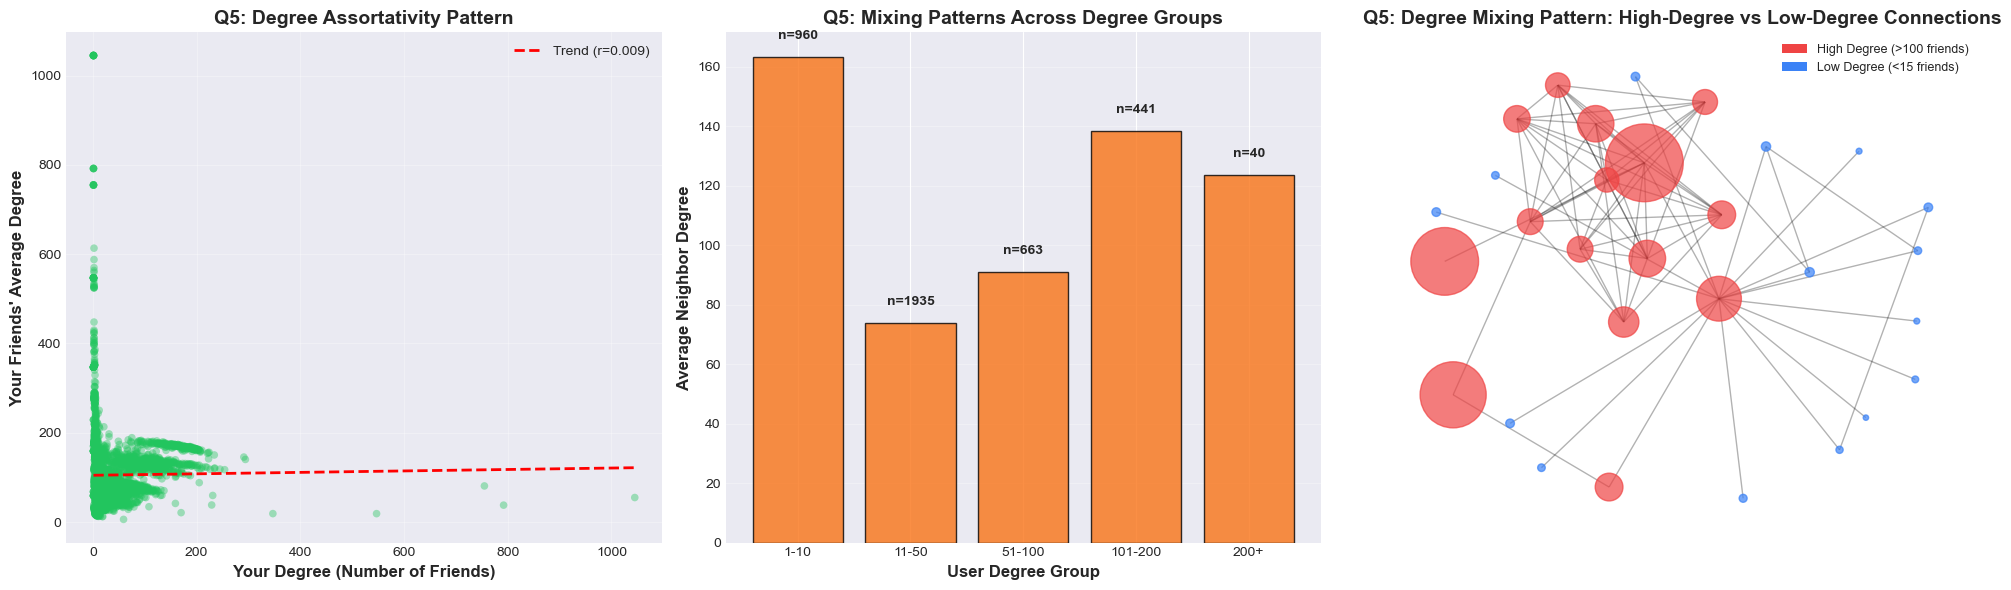

In [25]:
# Visualization: 3 plots for reserch question 5 - DEGREE ASSORTATIVITY & MIXING PATTERNS
fig5, axes5 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Degree vs Average Neighbor Degree
axes5[0].scatter(assortativity_df['degree'], assortativity_df['avg_neighbor_degree'], 
                alpha=0.4, s=30, color='#22C55E', edgecolors='none')
z = np.polyfit(assortativity_df['degree'], assortativity_df['avg_neighbor_degree'], 1)
p = np.poly1d(z)
axes5[0].plot(sorted(assortativity_df['degree']), p(sorted(assortativity_df['degree'])), 
             "r--", linewidth=2, label=f'Trend (r={pearson_corr:.3f})')
axes5[0].set_xlabel('Your Degree (Number of Friends)', fontsize=12, fontweight='bold')
axes5[0].set_ylabel("Your Friends' Average Degree", fontsize=12, fontweight='bold')
axes5[0].set_title('Q5: Degree Assortativity Pattern', fontsize=14, fontweight='bold')
axes5[0].legend()
axes5[0].grid(True, alpha=0.3)

# Plot 2: Mixing patterns by degree group
x_pos = np.arange(len(degree_mixing))
axes5[1].bar(x_pos, degree_mixing['avg_neighbor_degree'], color='#F97316', alpha=0.8, edgecolor='black')
axes5[1].set_xticks(x_pos)
axes5[1].set_xticklabels(degree_mixing['degree_bin'])
axes5[1].set_xlabel('User Degree Group', fontsize=12, fontweight='bold')
axes5[1].set_ylabel("Average Neighbor Degree", fontsize=12, fontweight='bold')
axes5[1].set_title('Q5: Mixing Patterns Across Degree Groups', fontsize=14, fontweight='bold')
axes5[1].grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(degree_mixing.iterrows()):
    axes5[1].text(i, row['avg_neighbor_degree'] + 5, f"n={row['count']}", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: NETWORK GRAPH - Assortativity Visualization

# Sample nodes from different degree ranges
low_degree_nodes = [n for n in G.nodes() if 5 <= degrees[n] <= 15][:15]
high_degree_nodes = [n for n in G.nodes() if degrees[n] > 100][:15]
sample_assort_nodes = low_degree_nodes + high_degree_nodes

# Create subgraph
assort_network = G.subgraph(sample_assort_nodes)

# Create layout
pos_assort = nx.spring_layout(assort_network, k=1.5, iterations=50, seed=42)

# Color by degree
node_colors_assort = []
for node in assort_network.nodes():
    if degrees[node] > 100:
        node_colors_assort.append('#EF4444')  # Red for high degree
    else:
        node_colors_assort.append('#3B82F6')  # Blue for low degree

# Node sizes by degree
node_sizes_assort = [degrees[node] * 3 for node in assort_network.nodes()]

# Draw network
nx.draw_networkx_nodes(assort_network, pos_assort, node_color=node_colors_assort, 
                       node_size=node_sizes_assort, alpha=0.7, ax=axes5[2])
nx.draw_networkx_edges(assort_network, pos_assort, alpha=0.3, width=1, ax=axes5[2])

axes5[2].set_title('Q5: Degree Mixing Pattern: High-Degree vs Low-Degree Connections', 
                   fontsize=14, fontweight='bold')
axes5[2].axis('off')

# Add legend
legend_elements_assort = [
    Patch(facecolor='#EF4444', label='High Degree (>100 friends)'),
    Patch(facecolor='#3B82F6', label='Low Degree (<15 friends)')
]
axes5[2].legend(handles=legend_elements_assort, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


In [26]:
# RESEARCH QUESTION 6: NETWORK RESILIENCE & VULNERABILITY
print("\n")
print("RESEARCH QUESTION 6: NETWORK RESILIENCE & VULNERABILITY")
print("How robust is the network to node removal?")
print("\n")







RESEARCH QUESTION 6: NETWORK RESILIENCE & VULNERABILITY
How robust is the network to node removal?




In [27]:
# Get initial largest component size
initial_lcc_size = len(max(nx.connected_components(G), key=len))

# Prepare for simulation
removal_fractions = np.linspace(0, 0.5, 26)
random_lcc_sizes = []
targeted_lcc_sizes = []

# Random removal simulation
print("  - Simulating random node removal...")
G_random = G.copy()
nodes_list = list(G_random.nodes())
np.random.seed(42)
np.random.shuffle(nodes_list)

for frac in removal_fractions:
    num_to_remove = int(frac * G.number_of_nodes())
    if num_to_remove > 0:
        nodes_to_remove = nodes_list[:num_to_remove]
        G_temp = G.copy()
        G_temp.remove_nodes_from(nodes_to_remove)
        if G_temp.number_of_nodes() > 0:
            lcc_size = len(max(nx.connected_components(G_temp), key=len))
            random_lcc_sizes.append(lcc_size / initial_lcc_size)
        else:
            random_lcc_sizes.append(0)
    else:
        random_lcc_sizes.append(1.0)

# Targeted removal simulation (remove highest degree nodes first)
print("  - Simulating targeted attack on high-degree nodes...")
sorted_by_degree = sorted(G.nodes(), key=lambda x: degrees[x], reverse=True)

for frac in removal_fractions:
    num_to_remove = int(frac * G.number_of_nodes())
    if num_to_remove > 0:
        nodes_to_remove = sorted_by_degree[:num_to_remove]
        G_temp = G.copy()
        G_temp.remove_nodes_from(nodes_to_remove)
        if G_temp.number_of_nodes() > 0:
            lcc_size = len(max(nx.connected_components(G_temp), key=len))
            targeted_lcc_sizes.append(lcc_size / initial_lcc_size)
        else:
            targeted_lcc_sizes.append(0)
    else:
        targeted_lcc_sizes.append(1.0)






  - Simulating random node removal...
  - Simulating targeted attack on high-degree nodes...


In [28]:
# Create resilience dataframe
resilience_df = pd.DataFrame({
    'removal_fraction': removal_fractions,
    'random_lcc': random_lcc_sizes,
    'targeted_lcc': targeted_lcc_sizes,
    'difference': [r - t for r, t in zip(random_lcc_sizes, targeted_lcc_sizes)]
})

# Find fragmentation thresholds (when LCC drops below 50%)
random_threshold = resilience_df[resilience_df['random_lcc'] < 0.5]['removal_fraction'].min() if any(resilience_df['random_lcc'] < 0.5) else None
targeted_threshold = resilience_df[resilience_df['targeted_lcc'] < 0.5]['removal_fraction'].min() if any(resilience_df['targeted_lcc'] < 0.5) else None

# Summary statistics
resilience_stats = pd.DataFrame({
    'Metric': [
        'Initial Network Size',
        'Random Failure Threshold (50% LCC)',
        'Targeted Attack Threshold (50% LCC)',
        'Resilience Ratio (Random/Targeted)',
        'LCC after 10% Random Removal',
        'LCC after 10% Targeted Removal'
    ],
    'Value': [
        f'{initial_lcc_size}',
        f'{random_threshold*100:.1f}%' if random_threshold else '>50%',
        f'{targeted_threshold*100:.1f}%' if targeted_threshold else '>50%',
        f'{random_threshold/targeted_threshold:.2f}x' if random_threshold and targeted_threshold else 'N/A',
        f'{resilience_df[resilience_df["removal_fraction"] == 0.1]["random_lcc"].values[0]*100:.1f}%',
        f'{resilience_df[resilience_df["removal_fraction"] == 0.1]["targeted_lcc"].values[0]*100:.1f}%'
    ]
})

print("NETWORK RESILIENCE ANALYSIS:")
display(resilience_stats)

print("\n")
print("RESILIENCE DATA (Selected Points):")
display(resilience_df[resilience_df['removal_fraction'].isin([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])])

print("\n")
print("KEY FINDINGS:")
print(f"• Network is {'HIGHLY VULNERABLE' if targeted_threshold and targeted_threshold < 0.15 else 'MODERATELY RESILIENT'} to targeted attacks")
print(f"• Random failures: {resilience_df[resilience_df['removal_fraction'] == 0.2]['random_lcc'].values[0]*100:.1f}% connectivity after 20% removal")
print(f"• Targeted attacks: {resilience_df[resilience_df['removal_fraction'] == 0.2]['targeted_lcc'].values[0]*100:.1f}% connectivity after 20% removal")
if targeted_threshold:
    print(f"• Critical threshold: Network fragments when {targeted_threshold*100:.1f}% of high-degree nodes are removed")
print("\n")

NETWORK RESILIENCE ANALYSIS:


,Metric,Value
0,Initial Network Size,4039
1,Random Failure Threshold (50% LCC),48.0%
2,Targeted Attack Threshold (50% LCC),24.0%
3,Resilience Ratio (Random/Targeted),2.00x
4,LCC after 10% Random Removal,90.0%
5,LCC after 10% Targeted Removal,87.8%




RESILIENCE DATA (Selected Points):


,removal_fraction,random_lcc,targeted_lcc,difference
0,0.0,1.000000,1.000000,0.000000
5,0.1,0.900223,0.877940,0.022283
10,0.2,0.796979,0.658084,0.138896
15,0.3,0.683833,0.400842,0.282991
20,0.4,0.578609,0.327061,0.251547
25,0.5,0.468185,0.226789,0.241396




KEY FINDINGS:
• Network is MODERATELY RESILIENT to targeted attacks
• Random failures: 79.7% connectivity after 20% removal
• Targeted attacks: 65.8% connectivity after 20% removal
• Critical threshold: Network fragments when 24.0% of high-degree nodes are removed




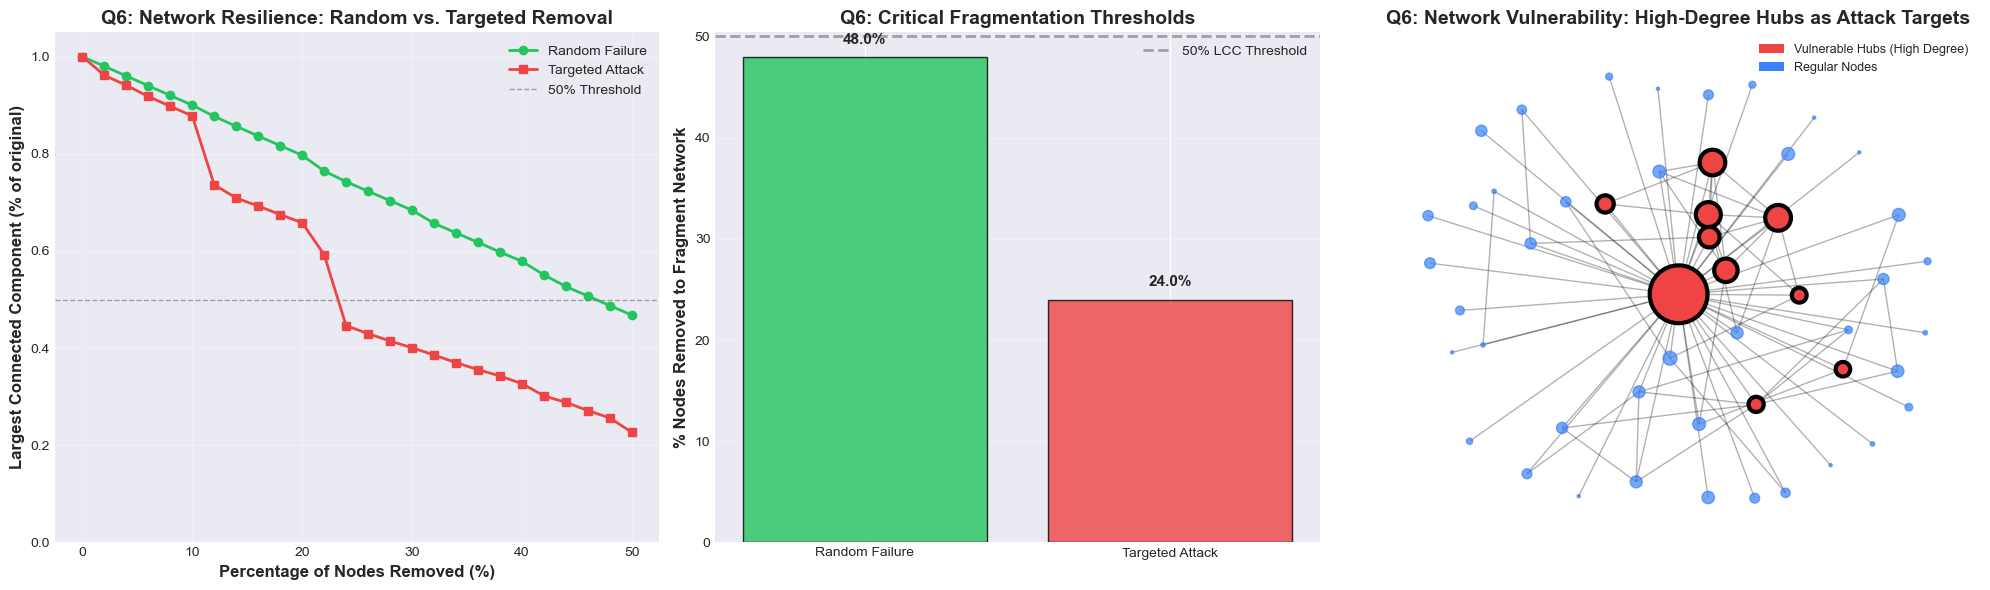

In [29]:
# Visualization: 3 plots for research question 6- NETWORK RESILIENCE & VULNERABILITY
fig6, axes6 = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Resilience curves
axes6[0].plot(removal_fractions * 100, random_lcc_sizes, 'o-', linewidth=2, markersize=6, 
              color='#22C55E', label='Random Failure')
axes6[0].plot(removal_fractions * 100, targeted_lcc_sizes, 's-', linewidth=2, markersize=6, 
              color='#EF4444', label='Targeted Attack')
axes6[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='50% Threshold')
axes6[0].set_xlabel('Percentage of Nodes Removed (%)', fontsize=12, fontweight='bold')
axes6[0].set_ylabel('Largest Connected Component (% of original)', fontsize=12, fontweight='bold')
axes6[0].set_title('Q6: Network Resilience: Random vs. Targeted Removal', fontsize=14, fontweight='bold')
axes6[0].legend()
axes6[0].grid(True, alpha=0.3)
axes6[0].set_ylim([0, 1.05])

# Plot 2: Critical thresholds comparison
threshold_data = pd.DataFrame({
    'Attack Type': ['Random Failure', 'Targeted Attack'],
    'Threshold (%)': [
        random_threshold * 100 if random_threshold else 50,
        targeted_threshold * 100 if targeted_threshold else 50
    ]
})
axes6[1].bar(threshold_data['Attack Type'], threshold_data['Threshold (%)'], 
             color=['#22C55E', '#EF4444'], alpha=0.8, edgecolor='black')
axes6[1].axhline(y=50, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='50% LCC Threshold')
axes6[1].set_ylabel('% Nodes Removed to Fragment Network', fontsize=12, fontweight='bold')
axes6[1].set_title('Q6: Critical Fragmentation Thresholds', fontsize=14, fontweight='bold')
axes6[1].grid(True, alpha=0.3, axis='y')
axes6[1].legend()

# Add value labels on bars
for i, row in threshold_data.iterrows():
    axes6[1].text(i, row['Threshold (%)'] + 1, f"{row['Threshold (%)']:.1f}%", 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: NETWORK GRAPH - Resilience Visualization (Before and After Attack)

# Show a small subgraph before and after targeted attack
# Sample a connected component
sample_size = 50
sample_nodes = list(G.nodes())[:sample_size]
resilience_network = G.subgraph(sample_nodes)

# Identify high-degree nodes in this sample
high_degree_in_sample = sorted(resilience_network.nodes(), 
                               key=lambda x: degrees[x], reverse=True)[:10]

# Create layout
pos_resilience = nx.spring_layout(resilience_network, k=1, iterations=50, seed=42)

# Color nodes: red for high-degree (vulnerable), blue for others
node_colors_resilience = []
for node in resilience_network.nodes():
    if node in high_degree_in_sample:
        node_colors_resilience.append('#EF4444')  # Red for vulnerable hubs
    else:
        node_colors_resilience.append('#3B82F6')  # Blue for regular nodes

# Node sizes by degree
node_sizes_resilience = [degrees[node] * 5 for node in resilience_network.nodes()]

# Draw network
nx.draw_networkx_nodes(resilience_network, pos_resilience, node_color=node_colors_resilience, 
                       node_size=node_sizes_resilience, alpha=0.7, ax=axes6[2])
nx.draw_networkx_edges(resilience_network, pos_resilience, alpha=0.3, width=1, ax=axes6[2])

# Highlight vulnerable nodes with thick border
nx.draw_networkx_nodes(resilience_network, pos_resilience, nodelist=high_degree_in_sample, 
                       node_color='#EF4444', node_size=[degrees[n] * 5 for n in high_degree_in_sample], 
                       edgecolors='black', linewidths=3, ax=axes6[2])

axes6[2].set_title('Q6: Network Vulnerability: High-Degree Hubs as Attack Targets', 
                   fontsize=14, fontweight='bold')
axes6[2].axis('off')

# Add legend
legend_elements_resilience = [
    Patch(facecolor='#EF4444', label='Vulnerable Hubs (High Degree)'),
    Patch(facecolor='#3B82F6', label='Regular Nodes')
]
axes6[2].legend(handles=legend_elements_resilience, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


In [30]:
print("SAVING ALL GRAPHS AS HIGH-QUALITY IMAGES (600 DPI)")
print("\n")

# Create a directory to save figures if it doesn't exist
output_dir = 'facebook_network_analysis_figures'
os.makedirs(output_dir, exist_ok=True)

# List of all figures to save
figures_to_save = [
    ('fig1', 'Q1_Community_Internal_External_and_Cohesion.png'),
    ('fig2', 'Q2_Friendship_Paradox_Analysis.png'),
    ('fig3', 'Q3_Triadic_Closure_Analysis.png'),
    ('fig4', 'Q4_Bridge_Nodes_Analysis.png'),
    ('fig5', 'Q5_Degree_Assortativity_Analysis.png'),
    ('fig6', 'Q6_Network_Resilience_Analysis.png')
]

print(f"Saving location: {os.path.abspath(output_dir)}\n")

saved_count = 0
for fig_var, filename in figures_to_save:
    try:
        # Get the figure object
        fig = eval(fig_var)
        
        # Full output path
        output_path = os.path.join(output_dir, filename)
        
        # Save the figure at very high resolution (600 DPI)
        fig.savefig(
            output_path,
            dpi=600,                 
            bbox_inches='tight',     
            pad_inches=0.2,          
            facecolor='white'        
        )
        
        print(f" High-quality image saved as: {filename}")
        saved_count += 1
        
    except NameError:
        print(f" Skipped: {filename} (figure '{fig_var}' not found in memory)")
    except Exception as e:
        print(f" Error saving {filename}: {str(e)}")

print("\n")
print(f"SUCCESSFULLY SAVED {saved_count} HIGH-QUALITY IMAGES!")
print(f"\n Location: {os.path.abspath(output_dir)}")
print("\n Files saved:")
for i, (_, filename) in enumerate(figures_to_save, 1):
    print(f"  {i}. {filename}")




SAVING ALL GRAPHS AS HIGH-QUALITY IMAGES (600 DPI)


Saving location: C:\Users\hp\facebook_network_analysis_figures

 High-quality image saved as: Q1_Community_Internal_External_and_Cohesion.png
 High-quality image saved as: Q2_Friendship_Paradox_Analysis.png
 High-quality image saved as: Q3_Triadic_Closure_Analysis.png
 High-quality image saved as: Q4_Bridge_Nodes_Analysis.png
 High-quality image saved as: Q5_Degree_Assortativity_Analysis.png
 High-quality image saved as: Q6_Network_Resilience_Analysis.png


SUCCESSFULLY SAVED 6 HIGH-QUALITY IMAGES!

 Location: C:\Users\hp\facebook_network_analysis_figures

 Files saved:
  1. Q1_Community_Internal_External_and_Cohesion.png
  2. Q2_Friendship_Paradox_Analysis.png
  3. Q3_Triadic_Closure_Analysis.png
  4. Q4_Bridge_Nodes_Analysis.png
  5. Q5_Degree_Assortativity_Analysis.png
  6. Q6_Network_Resilience_Analysis.png
